In [1]:
from __future__ import print_function
import pickle
from matplotlib import pyplot
import numpy as np
import os
import random
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from IPython.core.debugger import set_trace
from sklearn.metrics import roc_curve, auc, roc_auc_score
from PIL import Image
from PIL import ImageDraw
from PIL import ImageFont
PATHDOM = './siamesedom.pt'
PATHPROC = './siameseproc.pt'

In [2]:
# !sudo apt-get --purge --reinstall install ttf-mscorefonts-installer

In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
device

device(type='cuda')

In [4]:
# dataset_type = 'process'
dataset_type = 'domain'

OUTPUT_DIR = 'output'

if dataset_type == 'domain':
    OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'domain_results.pkl')
    INPUT_FILE = os.path.join('./data', 'domains_spoof.pkl')
    IMAGE_FILE = os.path.join(OUTPUT_DIR, 'domains_roc_curve.png')
    OUTPUT_NAME = 'Domain Spoofing'
elif dataset_type == 'process':
    OUTPUT_FILE = os.path.join(OUTPUT_DIR, 'process_results.pkl')
    INPUT_FILE = os.path.join('./data', 'process_spoof.pkl')
    IMAGE_FILE = os.path.join(OUTPUT_DIR, 'process_roc_curve.png')
    OUTPUT_NAME = 'Process Spoofing'
else:
    raise Exception('Unknown dataset type: %s' % (dataset_type,))

In [5]:
def generate_imgs(strings, font_location, font_size, image_size, text_location):
    font = ImageFont.truetype(font_location, font_size)

    str_imgs = []

    for st in strings:
        # Create a single channel image of floats
        img1 = Image.new('F', image_size)
        dimg = ImageDraw.Draw(img1)
        dimg.text(text_location, st.lower(), font=font)
        
        img1 = np.expand_dims(img1, axis=0)

        str_imgs.append(img1)

    return np.array(str_imgs, dtype=np.float32)

In [7]:
font_location = "Arial.ttf"
font_size = 10
image_size = (150, 12)
text_location = (0, 0)

with open(INPUT_FILE, 'rb') as f:
    data = pickle.load(f)
    print(len(data['train']))
    print(len(data['validate']))
    print(len(data['test']))
        
data['train'] = random.sample(data['train'], 800000)
data['validate'] = random.sample(data['validate'], 50000)
# data['test'] = random.sample(data['test'], 50000)

976122
51380
256886


In [8]:
X1_train = generate_imgs([x[0] for x in data['train']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) ) 
X2_train = generate_imgs([x[1] for x in data['train']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
y_train = [x[2] for x in data['train']]

X1_valid = generate_imgs([x[0] for x in data['validate']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
X2_valid = generate_imgs([x[1] for x in data['validate']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
y_valid = [x[2] for x in data['validate']]

# X1_test = generate_imgs([x[0] for x in data['test']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
# X2_test = generate_imgs([x[1] for x in data['test']], font_location, font_size, image_size, text_location).transpose( (0,2,3,1) )
# y_test = [x[2] for x in data['test']]

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0


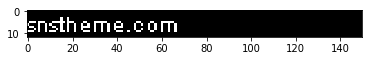

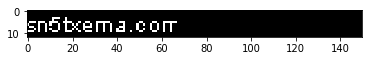

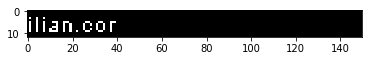

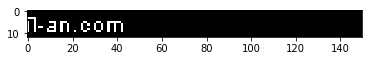

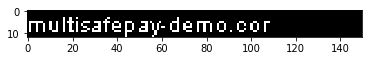

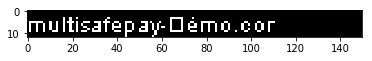

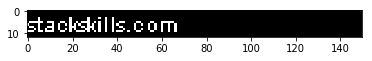

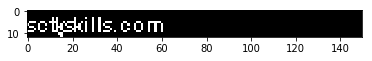

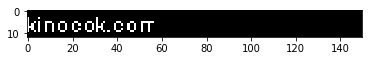

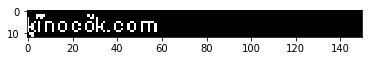

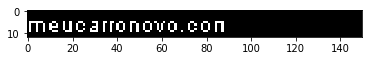

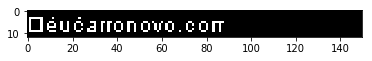

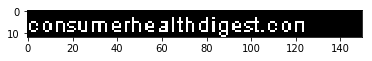

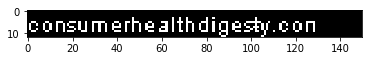

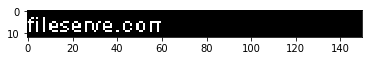

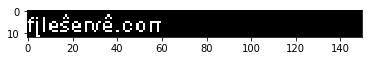

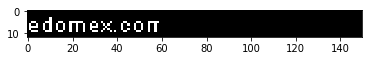

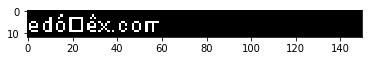

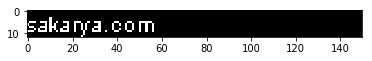

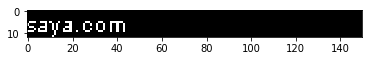

In [9]:
for ii in range(20, 30):
    iii = X1_train[ii].reshape((12, 150))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
    
    iii = X2_train[ii].reshape((12, 150))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
    
    print(y_train[ii])

In [10]:
def permute_shapes(collection):
    return collection.permute(0, 3, 1, 2)

def tensorify(collection):
    return torch.from_numpy(collection)

def arrange_dataset(X1, X2, y, batch_size=8, shuffle=True):
    X1_new = X1.unsqueeze(1)
    X2_new = X2.unsqueeze(1)
    y_new = torch.FloatTensor(y)
    
    dataset_large = torch.cat((X1_new, X2_new), 1)
    print(dataset_large.shape)
    print(y_new.shape)

    from torch.utils.data import DataLoader
    from torch.utils.data import TensorDataset
    dataset_large = dataset_large.to(device)
    y_new = y_new.to(device)
    large_dataset = TensorDataset(dataset_large, y_new)
    large_data_loader = DataLoader(large_dataset, batch_size=batch_size, shuffle=shuffle, drop_last=True)
    return large_data_loader

X1_train = permute_shapes(tensorify(X1_train))
X2_train = permute_shapes(tensorify(X2_train))
X1_valid = permute_shapes(tensorify(X1_valid))
X2_valid = permute_shapes(tensorify(X2_valid))
# X1_test = permute_shapes(tensorify(X1_test))
# X2_test = permute_shapes(tensorify(X2_test))

train_loader = arrange_dataset(X1_train, X2_train, y_train)
valid_loader = arrange_dataset(X1_valid, X2_valid, y_valid)
# test_loader = arrange_dataset(X1_test, X2_test, y_test)

torch.Size([800000, 2, 1, 12, 150])
torch.Size([800000])
torch.Size([50000, 2, 1, 12, 150])
torch.Size([50000])


In [11]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin=margin

    def forward(self, output1, output2, label):
        output1 = output1.type(torch.FloatTensor)
        output2 = output2.type(torch.FloatTensor)
        label = label.type(torch.FloatTensor)

        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean(label * torch.pow(euclidean_distance, 2) +
                                      (1 - label)   * torch.pow(torch.clamp(self.margin-euclidean_distance, min=0.0), 2))

        return loss_contrastive

class Siamese_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=128, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3)
        self.fc = nn.Linear(64 * 35, 32)

    def forward_once(self, x):
        x = F.leaky_relu(self.conv1(x), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = F.leaky_relu(self.conv2(x), 0.1)
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 64 * 35)
        return self.fc(x)
    
    def forward(self, input1, input2):
        return self.forward_once(torch.cat((input1, input2), 0))

Train Epoch: 1 [0/800000 (0%)]	Loss: 0.185249
Train Epoch: 1 [50000/800000 (6%)]	Loss: 0.155563
Train Epoch: 1 [100000/800000 (12%)]	Loss: 0.055288
Train Epoch: 1 [150000/800000 (19%)]	Loss: 0.183758
Train Epoch: 1 [200000/800000 (25%)]	Loss: 0.059837
Train Epoch: 1 [250000/800000 (31%)]	Loss: 0.189122
Train Epoch: 1 [300000/800000 (38%)]	Loss: 0.134071
Train Epoch: 1 [350000/800000 (44%)]	Loss: 0.137048
Train Epoch: 1 [400000/800000 (50%)]	Loss: 0.174638
Train Epoch: 1 [450000/800000 (56%)]	Loss: 0.086747
Train Epoch: 1 [500000/800000 (62%)]	Loss: 0.122625
Train Epoch: 1 [550000/800000 (69%)]	Loss: 0.047894
Train Epoch: 1 [600000/800000 (75%)]	Loss: 0.062562
Train Epoch: 1 [650000/800000 (81%)]	Loss: 0.120868
Train Epoch: 1 [700000/800000 (88%)]	Loss: 0.071645
Train Epoch: 1 [750000/800000 (94%)]	Loss: 0.088610


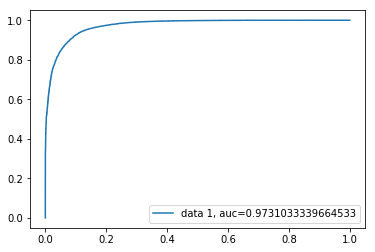


Test set: Average loss: 0.0869

Train Epoch: 2 [0/800000 (0%)]	Loss: 0.199846
Train Epoch: 2 [50000/800000 (6%)]	Loss: 0.069349
Train Epoch: 2 [100000/800000 (12%)]	Loss: 0.106942
Train Epoch: 2 [150000/800000 (19%)]	Loss: 0.118942
Train Epoch: 2 [200000/800000 (25%)]	Loss: 0.193885
Train Epoch: 2 [250000/800000 (31%)]	Loss: 0.132450
Train Epoch: 2 [300000/800000 (38%)]	Loss: 0.102806
Train Epoch: 2 [350000/800000 (44%)]	Loss: 0.214919
Train Epoch: 2 [400000/800000 (50%)]	Loss: 0.196878
Train Epoch: 2 [450000/800000 (56%)]	Loss: 0.162230
Train Epoch: 2 [500000/800000 (62%)]	Loss: 0.087374
Train Epoch: 2 [550000/800000 (69%)]	Loss: 0.132838
Train Epoch: 2 [600000/800000 (75%)]	Loss: 0.072227
Train Epoch: 2 [650000/800000 (81%)]	Loss: 0.081772
Train Epoch: 2 [700000/800000 (88%)]	Loss: 0.066104
Train Epoch: 2 [750000/800000 (94%)]	Loss: 0.055027


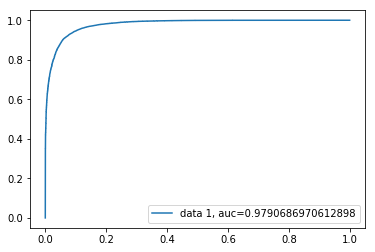


Test set: Average loss: 0.0862

Train Epoch: 3 [0/800000 (0%)]	Loss: 0.045676
Train Epoch: 3 [50000/800000 (6%)]	Loss: 0.110948
Train Epoch: 3 [100000/800000 (12%)]	Loss: 0.034045
Train Epoch: 3 [150000/800000 (19%)]	Loss: 0.133040
Train Epoch: 3 [200000/800000 (25%)]	Loss: 0.106078
Train Epoch: 3 [250000/800000 (31%)]	Loss: 0.095136
Train Epoch: 3 [300000/800000 (38%)]	Loss: 0.168179
Train Epoch: 3 [350000/800000 (44%)]	Loss: 0.084496
Train Epoch: 3 [400000/800000 (50%)]	Loss: 0.064848
Train Epoch: 3 [450000/800000 (56%)]	Loss: 0.073993
Train Epoch: 3 [500000/800000 (62%)]	Loss: 0.079763
Train Epoch: 3 [550000/800000 (69%)]	Loss: 0.146596
Train Epoch: 3 [600000/800000 (75%)]	Loss: 0.180094
Train Epoch: 3 [650000/800000 (81%)]	Loss: 0.094113
Train Epoch: 3 [700000/800000 (88%)]	Loss: 0.122969
Train Epoch: 3 [750000/800000 (94%)]	Loss: 0.082660


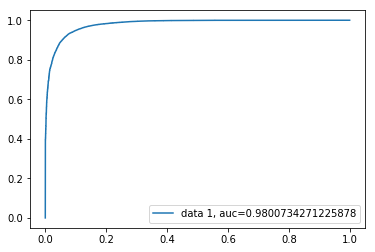


Test set: Average loss: 0.0849

Train Epoch: 4 [0/800000 (0%)]	Loss: 0.137770
Train Epoch: 4 [50000/800000 (6%)]	Loss: 0.068364
Train Epoch: 4 [100000/800000 (12%)]	Loss: 0.158895
Train Epoch: 4 [150000/800000 (19%)]	Loss: 0.132491
Train Epoch: 4 [200000/800000 (25%)]	Loss: 0.119330
Train Epoch: 4 [250000/800000 (31%)]	Loss: 0.099798
Train Epoch: 4 [300000/800000 (38%)]	Loss: 0.113759
Train Epoch: 4 [350000/800000 (44%)]	Loss: 0.110922
Train Epoch: 4 [400000/800000 (50%)]	Loss: 0.126497
Train Epoch: 4 [450000/800000 (56%)]	Loss: 0.112952
Train Epoch: 4 [500000/800000 (62%)]	Loss: 0.195939
Train Epoch: 4 [550000/800000 (69%)]	Loss: 0.098441
Train Epoch: 4 [600000/800000 (75%)]	Loss: 0.130496
Train Epoch: 4 [650000/800000 (81%)]	Loss: 0.118371
Train Epoch: 4 [700000/800000 (88%)]	Loss: 0.123731
Train Epoch: 4 [750000/800000 (94%)]	Loss: 0.091669


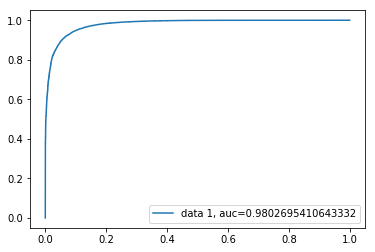


Test set: Average loss: 0.0846

Train Epoch: 5 [0/800000 (0%)]	Loss: 0.106841
Train Epoch: 5 [50000/800000 (6%)]	Loss: 0.082847
Train Epoch: 5 [100000/800000 (12%)]	Loss: 0.044394
Train Epoch: 5 [150000/800000 (19%)]	Loss: 0.127542
Train Epoch: 5 [200000/800000 (25%)]	Loss: 0.177846
Train Epoch: 5 [250000/800000 (31%)]	Loss: 0.046237
Train Epoch: 5 [300000/800000 (38%)]	Loss: 0.098376
Train Epoch: 5 [350000/800000 (44%)]	Loss: 0.147891
Train Epoch: 5 [400000/800000 (50%)]	Loss: 0.169143
Train Epoch: 5 [450000/800000 (56%)]	Loss: 0.107700
Train Epoch: 5 [500000/800000 (62%)]	Loss: 0.081295
Train Epoch: 5 [550000/800000 (69%)]	Loss: 0.068997
Train Epoch: 5 [600000/800000 (75%)]	Loss: 0.063552
Train Epoch: 5 [650000/800000 (81%)]	Loss: 0.103192
Train Epoch: 5 [700000/800000 (88%)]	Loss: 0.137442
Train Epoch: 5 [750000/800000 (94%)]	Loss: 0.084468


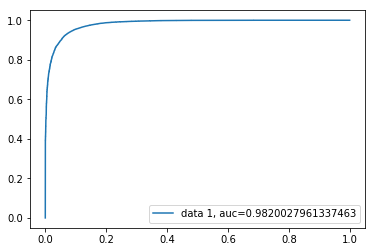


Test set: Average loss: 0.0801

Train Epoch: 6 [0/800000 (0%)]	Loss: 0.203938
Train Epoch: 6 [50000/800000 (6%)]	Loss: 0.092518
Train Epoch: 6 [100000/800000 (12%)]	Loss: 0.044675
Train Epoch: 6 [150000/800000 (19%)]	Loss: 0.079568
Train Epoch: 6 [200000/800000 (25%)]	Loss: 0.071340
Train Epoch: 6 [250000/800000 (31%)]	Loss: 0.102439
Train Epoch: 6 [300000/800000 (38%)]	Loss: 0.054739
Train Epoch: 6 [350000/800000 (44%)]	Loss: 0.063670
Train Epoch: 6 [400000/800000 (50%)]	Loss: 0.065793
Train Epoch: 6 [450000/800000 (56%)]	Loss: 0.056676
Train Epoch: 6 [500000/800000 (62%)]	Loss: 0.048895
Train Epoch: 6 [550000/800000 (69%)]	Loss: 0.078713
Train Epoch: 6 [600000/800000 (75%)]	Loss: 0.103261
Train Epoch: 6 [650000/800000 (81%)]	Loss: 0.185331
Train Epoch: 6 [700000/800000 (88%)]	Loss: 0.019925
Train Epoch: 6 [750000/800000 (94%)]	Loss: 0.092518


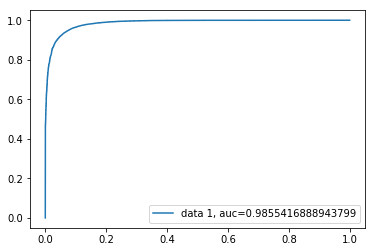


Test set: Average loss: 0.0721

Train Epoch: 7 [0/800000 (0%)]	Loss: 0.069162
Train Epoch: 7 [50000/800000 (6%)]	Loss: 0.108097
Train Epoch: 7 [100000/800000 (12%)]	Loss: 0.100292
Train Epoch: 7 [150000/800000 (19%)]	Loss: 0.080606
Train Epoch: 7 [200000/800000 (25%)]	Loss: 0.058318
Train Epoch: 7 [250000/800000 (31%)]	Loss: 0.055894
Train Epoch: 7 [300000/800000 (38%)]	Loss: 0.152081
Train Epoch: 7 [350000/800000 (44%)]	Loss: 0.083846
Train Epoch: 7 [400000/800000 (50%)]	Loss: 0.124671
Train Epoch: 7 [450000/800000 (56%)]	Loss: 0.074136
Train Epoch: 7 [500000/800000 (62%)]	Loss: 0.087024
Train Epoch: 7 [550000/800000 (69%)]	Loss: 0.130115
Train Epoch: 7 [600000/800000 (75%)]	Loss: 0.036635
Train Epoch: 7 [650000/800000 (81%)]	Loss: 0.036781
Train Epoch: 7 [700000/800000 (88%)]	Loss: 0.066781
Train Epoch: 7 [750000/800000 (94%)]	Loss: 0.188786


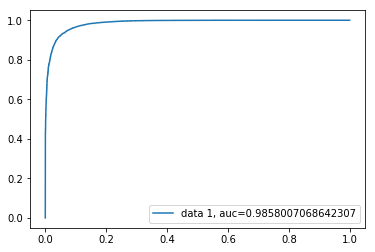


Test set: Average loss: 0.0720

Train Epoch: 8 [0/800000 (0%)]	Loss: 0.036522
Train Epoch: 8 [50000/800000 (6%)]	Loss: 0.053798
Train Epoch: 8 [100000/800000 (12%)]	Loss: 0.098182
Train Epoch: 8 [150000/800000 (19%)]	Loss: 0.092828
Train Epoch: 8 [200000/800000 (25%)]	Loss: 0.094106
Train Epoch: 8 [250000/800000 (31%)]	Loss: 0.103743
Train Epoch: 8 [300000/800000 (38%)]	Loss: 0.037752
Train Epoch: 8 [350000/800000 (44%)]	Loss: 0.134237
Train Epoch: 8 [400000/800000 (50%)]	Loss: 0.184402
Train Epoch: 8 [450000/800000 (56%)]	Loss: 0.096142
Train Epoch: 8 [500000/800000 (62%)]	Loss: 0.071259
Train Epoch: 8 [550000/800000 (69%)]	Loss: 0.101235
Train Epoch: 8 [600000/800000 (75%)]	Loss: 0.157701
Train Epoch: 8 [650000/800000 (81%)]	Loss: 0.120503
Train Epoch: 8 [700000/800000 (88%)]	Loss: 0.126176
Train Epoch: 8 [750000/800000 (94%)]	Loss: 0.085412


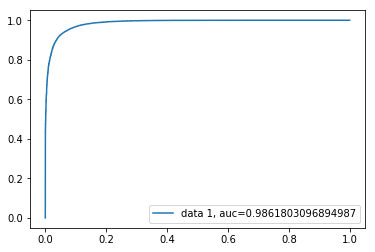


Test set: Average loss: 0.0712

Train Epoch: 9 [0/800000 (0%)]	Loss: 0.104392
Train Epoch: 9 [50000/800000 (6%)]	Loss: 0.079625
Train Epoch: 9 [100000/800000 (12%)]	Loss: 0.073580
Train Epoch: 9 [150000/800000 (19%)]	Loss: 0.109325
Train Epoch: 9 [200000/800000 (25%)]	Loss: 0.083238
Train Epoch: 9 [250000/800000 (31%)]	Loss: 0.077648
Train Epoch: 9 [300000/800000 (38%)]	Loss: 0.097998
Train Epoch: 9 [350000/800000 (44%)]	Loss: 0.047796
Train Epoch: 9 [400000/800000 (50%)]	Loss: 0.080592
Train Epoch: 9 [450000/800000 (56%)]	Loss: 0.076418
Train Epoch: 9 [500000/800000 (62%)]	Loss: 0.125831
Train Epoch: 9 [550000/800000 (69%)]	Loss: 0.131555
Train Epoch: 9 [600000/800000 (75%)]	Loss: 0.070949
Train Epoch: 9 [650000/800000 (81%)]	Loss: 0.058674
Train Epoch: 9 [700000/800000 (88%)]	Loss: 0.116912
Train Epoch: 9 [750000/800000 (94%)]	Loss: 0.078356


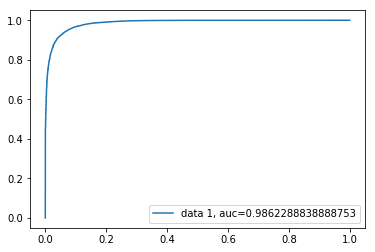


Test set: Average loss: 0.0716

Train Epoch: 10 [0/800000 (0%)]	Loss: 0.118240
Train Epoch: 10 [50000/800000 (6%)]	Loss: 0.078980
Train Epoch: 10 [100000/800000 (12%)]	Loss: 0.084521
Train Epoch: 10 [150000/800000 (19%)]	Loss: 0.083118
Train Epoch: 10 [200000/800000 (25%)]	Loss: 0.069891
Train Epoch: 10 [250000/800000 (31%)]	Loss: 0.017458
Train Epoch: 10 [300000/800000 (38%)]	Loss: 0.027326
Train Epoch: 10 [350000/800000 (44%)]	Loss: 0.030205
Train Epoch: 10 [400000/800000 (50%)]	Loss: 0.052292
Train Epoch: 10 [450000/800000 (56%)]	Loss: 0.035477
Train Epoch: 10 [500000/800000 (62%)]	Loss: 0.135123
Train Epoch: 10 [550000/800000 (69%)]	Loss: 0.035367
Train Epoch: 10 [600000/800000 (75%)]	Loss: 0.114747
Train Epoch: 10 [650000/800000 (81%)]	Loss: 0.045379
Train Epoch: 10 [700000/800000 (88%)]	Loss: 0.126272
Train Epoch: 10 [750000/800000 (94%)]	Loss: 0.070078


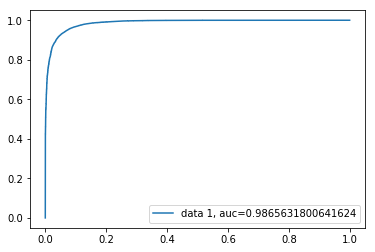


Test set: Average loss: 0.0711

Train Epoch: 11 [0/800000 (0%)]	Loss: 0.098417
Train Epoch: 11 [50000/800000 (6%)]	Loss: 0.085685
Train Epoch: 11 [100000/800000 (12%)]	Loss: 0.137246
Train Epoch: 11 [150000/800000 (19%)]	Loss: 0.119970
Train Epoch: 11 [200000/800000 (25%)]	Loss: 0.104220
Train Epoch: 11 [250000/800000 (31%)]	Loss: 0.135046
Train Epoch: 11 [300000/800000 (38%)]	Loss: 0.104683
Train Epoch: 11 [350000/800000 (44%)]	Loss: 0.096900
Train Epoch: 11 [400000/800000 (50%)]	Loss: 0.048194
Train Epoch: 11 [450000/800000 (56%)]	Loss: 0.061265
Train Epoch: 11 [500000/800000 (62%)]	Loss: 0.203356
Train Epoch: 11 [550000/800000 (69%)]	Loss: 0.039338
Train Epoch: 11 [600000/800000 (75%)]	Loss: 0.015305
Train Epoch: 11 [650000/800000 (81%)]	Loss: 0.024361
Train Epoch: 11 [700000/800000 (88%)]	Loss: 0.092327
Train Epoch: 11 [750000/800000 (94%)]	Loss: 0.051640


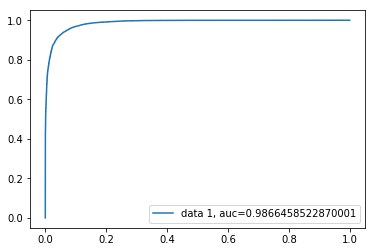


Test set: Average loss: 0.0709

Train Epoch: 12 [0/800000 (0%)]	Loss: 0.054373
Train Epoch: 12 [50000/800000 (6%)]	Loss: 0.069765
Train Epoch: 12 [100000/800000 (12%)]	Loss: 0.181929
Train Epoch: 12 [150000/800000 (19%)]	Loss: 0.035621
Train Epoch: 12 [200000/800000 (25%)]	Loss: 0.099787
Train Epoch: 12 [250000/800000 (31%)]	Loss: 0.125008
Train Epoch: 12 [300000/800000 (38%)]	Loss: 0.088954
Train Epoch: 12 [350000/800000 (44%)]	Loss: 0.088563
Train Epoch: 12 [400000/800000 (50%)]	Loss: 0.126031
Train Epoch: 12 [450000/800000 (56%)]	Loss: 0.022436
Train Epoch: 12 [500000/800000 (62%)]	Loss: 0.041324
Train Epoch: 12 [550000/800000 (69%)]	Loss: 0.190849
Train Epoch: 12 [600000/800000 (75%)]	Loss: 0.083055
Train Epoch: 12 [650000/800000 (81%)]	Loss: 0.190019
Train Epoch: 12 [700000/800000 (88%)]	Loss: 0.084419
Train Epoch: 12 [750000/800000 (94%)]	Loss: 0.205155


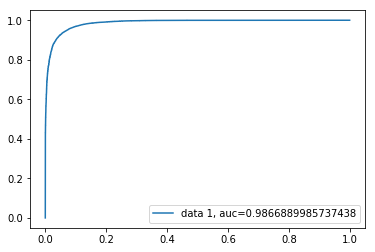


Test set: Average loss: 0.0708

Train Epoch: 13 [0/800000 (0%)]	Loss: 0.135952
Train Epoch: 13 [50000/800000 (6%)]	Loss: 0.052052
Train Epoch: 13 [100000/800000 (12%)]	Loss: 0.122430
Train Epoch: 13 [150000/800000 (19%)]	Loss: 0.076525
Train Epoch: 13 [200000/800000 (25%)]	Loss: 0.153787
Train Epoch: 13 [250000/800000 (31%)]	Loss: 0.105559
Train Epoch: 13 [300000/800000 (38%)]	Loss: 0.081339
Train Epoch: 13 [350000/800000 (44%)]	Loss: 0.072552
Train Epoch: 13 [400000/800000 (50%)]	Loss: 0.137256
Train Epoch: 13 [450000/800000 (56%)]	Loss: 0.066764
Train Epoch: 13 [500000/800000 (62%)]	Loss: 0.057163
Train Epoch: 13 [550000/800000 (69%)]	Loss: 0.072329
Train Epoch: 13 [600000/800000 (75%)]	Loss: 0.050986
Train Epoch: 13 [650000/800000 (81%)]	Loss: 0.073199
Train Epoch: 13 [700000/800000 (88%)]	Loss: 0.099458
Train Epoch: 13 [750000/800000 (94%)]	Loss: 0.103902


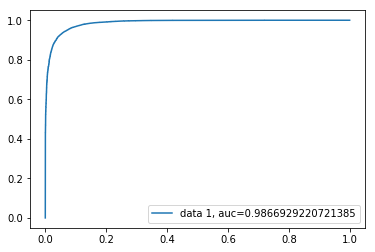


Test set: Average loss: 0.0708

Train Epoch: 14 [0/800000 (0%)]	Loss: 0.063014
Train Epoch: 14 [50000/800000 (6%)]	Loss: 0.053124
Train Epoch: 14 [100000/800000 (12%)]	Loss: 0.069598
Train Epoch: 14 [150000/800000 (19%)]	Loss: 0.067533
Train Epoch: 14 [200000/800000 (25%)]	Loss: 0.036406
Train Epoch: 14 [250000/800000 (31%)]	Loss: 0.086939
Train Epoch: 14 [300000/800000 (38%)]	Loss: 0.046869
Train Epoch: 14 [350000/800000 (44%)]	Loss: 0.099730
Train Epoch: 14 [400000/800000 (50%)]	Loss: 0.079288
Train Epoch: 14 [450000/800000 (56%)]	Loss: 0.119645
Train Epoch: 14 [500000/800000 (62%)]	Loss: 0.093164
Train Epoch: 14 [550000/800000 (69%)]	Loss: 0.045286
Train Epoch: 14 [600000/800000 (75%)]	Loss: 0.025373
Train Epoch: 14 [650000/800000 (81%)]	Loss: 0.067932
Train Epoch: 14 [700000/800000 (88%)]	Loss: 0.130624
Train Epoch: 14 [750000/800000 (94%)]	Loss: 0.115654


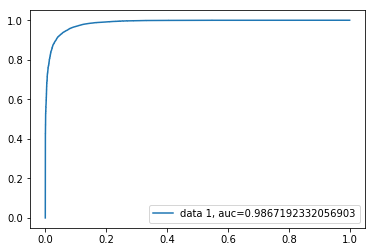


Test set: Average loss: 0.0708

Train Epoch: 15 [0/800000 (0%)]	Loss: 0.130985
Train Epoch: 15 [50000/800000 (6%)]	Loss: 0.256235
Train Epoch: 15 [100000/800000 (12%)]	Loss: 0.102926
Train Epoch: 15 [150000/800000 (19%)]	Loss: 0.051420
Train Epoch: 15 [200000/800000 (25%)]	Loss: 0.161862
Train Epoch: 15 [250000/800000 (31%)]	Loss: 0.079674
Train Epoch: 15 [300000/800000 (38%)]	Loss: 0.101772
Train Epoch: 15 [350000/800000 (44%)]	Loss: 0.055541
Train Epoch: 15 [400000/800000 (50%)]	Loss: 0.055248
Train Epoch: 15 [450000/800000 (56%)]	Loss: 0.088414
Train Epoch: 15 [500000/800000 (62%)]	Loss: 0.160849
Train Epoch: 15 [550000/800000 (69%)]	Loss: 0.096189
Train Epoch: 15 [600000/800000 (75%)]	Loss: 0.068263
Train Epoch: 15 [650000/800000 (81%)]	Loss: 0.137146
Train Epoch: 15 [700000/800000 (88%)]	Loss: 0.035558
Train Epoch: 15 [750000/800000 (94%)]	Loss: 0.084301


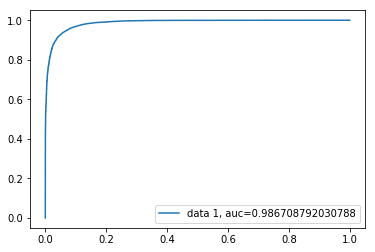


Test set: Average loss: 0.0707



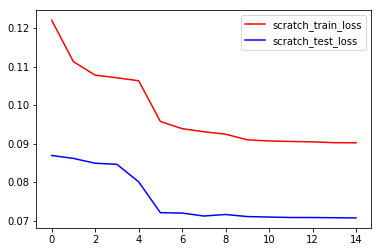

In [12]:
siamese = Siamese_CNN().to(device)
optimizer_siamese = optim.Adam(siamese.parameters(), lr=0.001)
lrscheduler = optim.lr_scheduler.StepLR(optimizer_siamese, step_size=4, gamma=0.1)

criterion = ContrastiveLoss().to(device)

def plot_loss(loss, label, color='blue'):
    pyplot.plot(loss, label=label, color=color)
    pyplot.legend()
    
    
def train(model, device, train_loader, optimizer, epoch, batch_size=8):
    log_interval = int(50000 / batch_size)
    
    model.train()
    train_loss = 0
    num_iter = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        # initialize as zeros all the gradients of the model
        optimizer.zero_grad()
        data, target = data.to(device), target.to(device)
        data_permuted = data.permute(1, 0, 2, 3, 4)
        data1 = data_permuted[0]
        data2 = data_permuted[1]
        
        output = model(data1, data2)
        output1 = output[:batch_size]
        output2 = output[batch_size:]
        
        # compute average loss for the current batch
        loss = criterion(output1, output2, target)
        train_loss += loss
        # backpropagate the gradients
        loss.backward()
        optimizer.step()
        num_iter += 1
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


    train_loss /= num_iter
    return train_loss.item()
            
def validate(model, device, validation_loader, optimizer, epoch, batch_size=8):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        num_iter = 0
        dists_acc = []
        targets_acc = []
        
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            data_permuted = data.permute(1, 0, 2, 3, 4)
            data1 = data_permuted[0]
            data2 = data_permuted[1]

            output = model(data1, data2)
            output1 = output[:batch_size]
            output2 = output[batch_size:]
            dists = F.pairwise_distance(output1, output2)
            dists_acc.extend(dists.cpu().detach().numpy())
            targets_acc.extend(target.cpu().detach().numpy())
            
            test_loss +=  criterion(output1, output2, target)
            num_iter += 1
    
    test_loss /= num_iter
    classified = -np.array(dists_acc)
    fpr, tpr, _ = roc_curve(np.array(targets_acc), classified)
    auc = roc_auc_score(targets_acc, classified)
    pyplot.plot(fpr,tpr,label="data 1, auc="+str(auc))
    pyplot.legend(loc=4)
    pyplot.show()

    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))
    return test_loss

  
losses_train_pre = []
losses_test_pre = []

for epoch in range(1, 15 + 1):    
    losses_train_pre.append(train(siamese, None, train_loader, optimizer_siamese, epoch))
    losses_test_pre.append(validate(siamese, None, valid_loader, optimizer_siamese, epoch))
    lrscheduler.step()
    
plot_loss(losses_train_pre,'scratch_train_loss','red')
plot_loss(losses_test_pre,'scratch_test_loss')

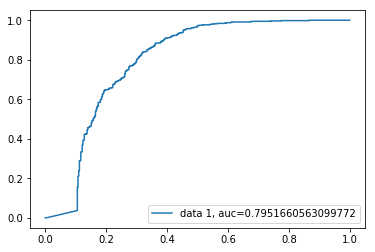

In [49]:
test_batch = test_loader.dataset.tensors[0].permute(1, 0, 2, 3, 4)
test_labels = test_loader.dataset.tensors[1].cpu().detach().numpy()
output = siamese(test_batch[0], test_batch[1])
outs1 = output[:1000]
outs2 = output[1000:]
dists = F.pairwise_distance(outs1, outs2)
classified = dists.cpu().detach().numpy()
fpr, tpr, _ = roc_curve(test_labels,  -classified)
auc = roc_auc_score(test_labels, -classified)
pyplot.plot(fpr,tpr,label="data 1, auc="+str(auc))
pyplot.legend(loc=4)
pyplot.show()


In [21]:
# torch.save(siamese, PATHDOM)
# torch.save(siamese.state_dict(),"siameseprocsd.pt")
loaded_state_dict = torch.load('siameseprocsd.pt')
x = Siamese_CNN().to(device)
x.load_state_dict(loaded_state_dict)
# loaded = torch.load(PATHPROC)

/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


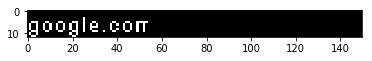

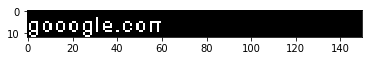

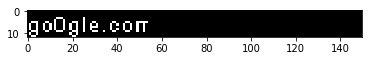

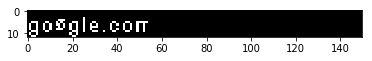

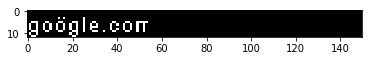

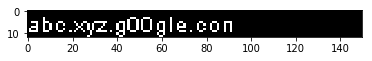

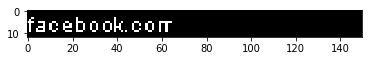

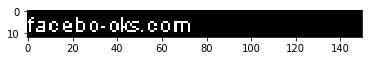

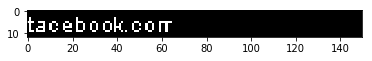

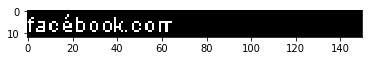

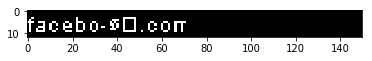

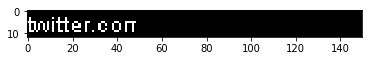

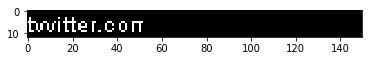

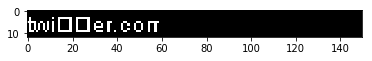

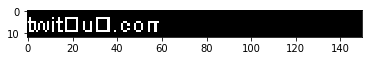

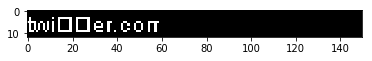

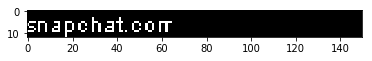

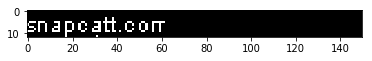

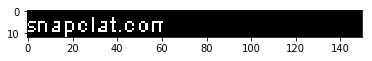

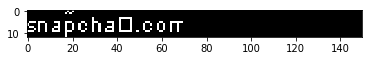

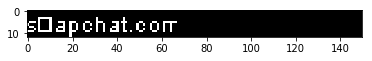

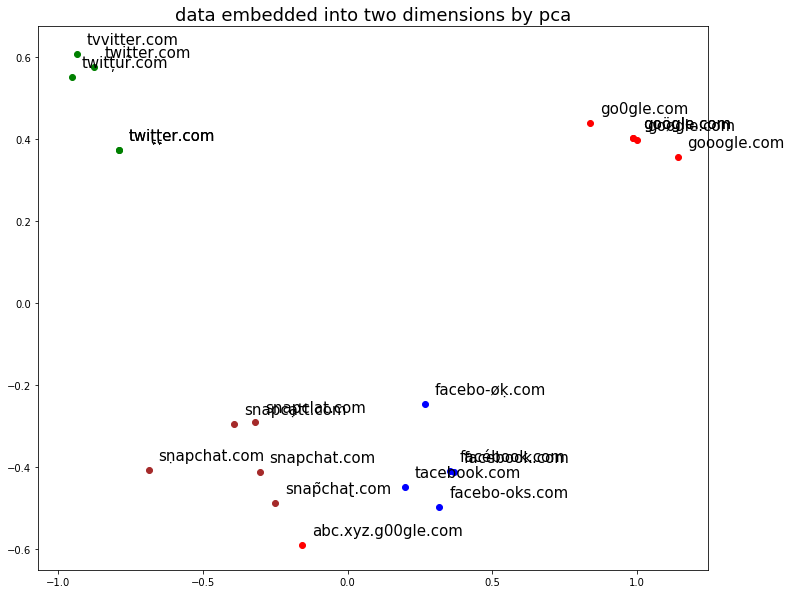

In [22]:
pca_test = ['google.com', 'gooogle.com', 'go0gle.com', 'goøgle.com', 'goögle.com', 'abc.xyz.g00gle.com',
            'facebook.com', 'facebo-oks.com', 'tacebook.com', 'facébook.com', 'facebo-øḳ.com',
            'twitter.com', 'tvvitter.com', 'twițțer.com', 'twitțuȓ.com', 'twiʈʈer.com',
            'snapchat.com', 'snapcạtt.com', 'snapclat.com', 'snap̃chaʈ.com', 'sṇapchat.com']
pca_images_test = torch.tensor(generate_imgs(pca_test, font_location, font_size, image_size, text_location))
for ii in range(len(pca_test)):
    iii = pca_images_test[ii].reshape((12, 150))
    pyplot.figure()
    pyplot.imshow(iii, cmap="gray")
    
pca_images_test = pca_images_test.to(device)

outputs = x(pca_images_test[:10], pca_images_test[10:])
labels = [0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3]
colors = ['red', 'blue', 'green', 'brown']

from sklearn.decomposition import IncrementalPCA
ipca = IncrementalPCA(n_components=2, batch_size=20)
pca_embedded = ipca.fit_transform(outputs.cpu().detach().numpy())
fig, ax = pyplot.subplots(figsize=(12, 10))


for i,type in enumerate(labels):
    x = pca_embedded[i][0]
    y = pca_embedded[i][1]
    pyplot.scatter(x, y, marker='o', color=colors[labels[i]])
    pyplot.annotate(pca_test[i], (x, y), fontsize=15, xytext=(10, 10), textcoords='offset points')
pyplot.title("data embedded into two dimensions by pca", fontsize=18)
pyplot.show()

In [92]:
for x1, x2, y in data['train']:
    if 'google' in x1:
        print(x1, x2, y)

thinkwithgoogle.com thinķwithgoogle.com 1.0
googleguide.com teleguide.com 0.0
iran-google.com iran-ġoogle.com 1.0
googlecode.com gøog-lecodě.com 1.0
googleratings.com googleapps.com 0.0
googleusercontent.com googleuśercontent.com 1.0
googlesyndication.com modernisation.com 0.0
googlesyndication.com pcgeducation.com 0.0
igoogleportal.com joomlaportal.com 0.0
googlecode.com googleguide.com 0.0
iran-google.com iranmobile.com 0.0
googletraveladservices.com googletrâvelãdservíces.com 1.0
googletraveladservices.com googl_etraveladsmrvicesh.com 1.0
googledrive.com googlecode.com 0.0
googledrive.com googieedriṿe.com 1.0


In [39]:
outputs = loaded(pca_images_test[0].unsqueeze(0), pca_images_test[5].unsqueeze(0))

In [48]:
F.pairwise_distance(outputs[:1], outputs[1:])

tensor([1.7702], device='cuda:0', grad_fn=<NormBackward1>)